In [1]:
import os
import random

import numpy as np
from numpy import linalg
import pandas as pd
import nibabel as nib
from joblib import Parallel, delayed

from neurolang import frontend as fe
from neurolang import regions
import neurolang.regions

/home/nikita/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
nl = fe.RegionFrontend()

AttributeError: module 'neurolang.frontend' has no attribute 'RegionFrontend'

In [4]:
 subject_ids = [
     '105923', '111514', '133019', '140117', '153732', '154532',
       '156334', '166438', '175540', '177746', '179245', '187547',
       '189349', '191841', '205119', '212823', '214524', '221319',
       '223929', '255639', '293748', '352132', '352738', '358144',
       '406836', '433839', '512835', '555348', '559053', '568963',
       '581450', '599671', '601127', '660951', '662551', '665254',
       '679770', '680957', '706040', '707749', '715950', '735148',
       '783462', '814649', '825048', '872764', '877168', '891667',
       '898176', '912447', '917255', '990366']

In [6]:
subj_files_path = '/home/amachlou/git/neurolang/examples/running_on_100/'

In [8]:
x_labels = ['medial', 'during_x', 'lateral']
y_labels =  ['anterior', 'during_y', 'posterior']
z_labels = ['superior', 'during_z', 'inferior']

In [10]:
# This function is not used in this notebook

# def make_planes_from_Callosal(primaries_dict, subject, limiting_sulcus):
#     limiter = primaries_dict[subject]['primaries'][limiting_sulcus]
#     if limiter is not np.nan:
#         x = max((limiter.value.to_xyz().T[0]), key=abs)
#         oxplane = regions.PlanarVolume((x, 0, 0), (1, 0, 0), limit=100)
#         ox_plane_vbr = oxplane.to_explicit_vbr(destrieux_map.affine, destrieux_map.shape)
#         nl.add_region(ox_plane_vbr, name='medial_from_call')

#         z = np.min((limiter.value.to_xyz().T[2]))
#         oxplane = regions.PlanarVolume((0, 0, z), (0, 0, 1), limit=100)
#         ox_plane_vbr = oxplane.to_explicit_vbr(destrieux_map.affine, destrieux_map.shape)
#         nl.add_region(ox_plane_vbr, name='ventral_from_call')
#     else:
#         pass

In [11]:
def voxel_relations_using_interval_algebra(ys_origin_sulcus, ys_target_sulcus, length):
    before=set()
    during=set()
    after=set()
    Anterior_of=set()
    Posterior_of=set()
    During=set()
    J_minus = min(ys_target_sulcus)
    J_plus = max(ys_target_sulcus) + length

    I_boxes = set(ys_origin_sulcus)
    for x in I_boxes:
        I_minus = x
        I_plus = I_minus + length

        if I_minus < I_plus < J_minus < J_plus:
            before.add(x)
        if J_minus < I_minus < I_plus < J_plus:
            during.add(x)
        if J_minus < J_plus < I_minus < I_plus:
            after.add(x)
    before_pc =  len(before) / len(I_boxes) * 100
    during_pc = len(during) / len(I_boxes) * 100
    after_pc = len(after) / len(I_boxes) * 100

    values = [before_pc, during_pc, after_pc]

    return values

In [12]:
def making_dominant_sets_relative_to_primary(info_dict, primary_sulcus, s, labels, nl, axis):
    if info_dict[s]['primaries'][primary_sulcus] is not np.nan:    
        x = nl.new_region_symbol('x')
        q = nl.query(
            x, 
            (
                nl.symbols.anterior_of(x, info_dict[s]['primaries'][primary_sulcus]) |
                nl.symbols.posterior_of(x, info_dict[s]['primaries'][primary_sulcus]) |
                nl.symbols.superior_of(x, info_dict[s]['primaries'][primary_sulcus]) |
                nl.symbols.inferior_of(x, info_dict[s]['primaries'][primary_sulcus])
            )
        )

        res = q.do()

        anterior=set()
        posterior=set()
        during_y=set()
        superior=set()
        inferior=set()
        during_z=set()
        medial=set()
        lateral=set()
        during_x=set()

        for r in res:
            if r.symbol_name.startswith('L_'):
                if r.symbol_name in info_dict[s]['destrieux_sulci'].keys():
                    sulcus_relativity = voxel_relations_using_interval_algebra(info_dict[s]['primaries'][primary_sulcus].value.to_xyz().T[axis], 
                                                      info_dict[s]['destrieux_sulci'][r.symbol_name].T[axis], length=.1)
                    relations=[]
                    relations.append(labels[np.argmax(np.array(sulcus_relativity))])
                    if mode(relations)=='anterior':
                        anterior.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='posterior':
                        posterior.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='during_y':
                        during_y.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='superior':
                        superior.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='inferior':
                        inferior.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='during_z':
                        during_z.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='medial':
                        medial.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='lateral':
                        lateral.add(nl.symbols[r.symbol_name])
                    elif mode(relations)=='during_x':
                        during_x.add(nl.symbols[r.symbol_name])
                    else:
                        continue
                else:
                    pass

            if axis==1:
                anterior_dominant = nl.add_region_set(anterior, name=f'{primary_sulcus}_anterior_dominant')
                posterior_dominant = nl.add_region_set(posterior, name=f'{primary_sulcus}_posterior_dominant')
                during_y_dominant = nl.add_region_set(during_y, name=f'{primary_sulcus}_during_y_dominant')
            elif axis==2:
                superior_dominant = nl.add_region_set(superior, name=f'{primary_sulcus}_superior_dominant')
                inferior_dominant = nl.add_region_set(inferior, name=f'{primary_sulcus}_inferior_dominant')
                during_z_dominant = nl.add_region_set(during_z, name=f'{primary_sulcus}_during_z_dominant')
            elif axis==0:
                medial_dominant = nl.add_region_set(medial, name=f'{primary_sulcus}_medial_dominant')
                lateral_dominant = nl.add_region_set(lateral, name=f'{primary_sulcus}_lateral_dominant')
                during_x_dominant = nl.add_region_set(during_x, name=f'{primary_sulcus}_during_x_dominant')
    else:
        pass

In [13]:
# This function is not used in this notebook

# def making_dominant_set_for_planes(plane, labels, s, subject_manual_sulci, axis):

#     x = nl.new_region_symbol('x')
#     q = nl.query(
#     x, 
#         (
#         nl.symbols.right_of(x, nl.symbols[plane]) |
#         nl.symbols.left_of(x, nl.symbols[plane]) |
#         nl.symbols.superior_of(x, nl.symbols[plane]) |
#         nl.symbols.inferior_of(x, nl.symbols[plane])
#         )
#     )

#     res = q.do()

#     superior=set()
#     inferior=set()
#     during_z=set()
#     medial=set()
#     lateral=set()
#     during_x=set()

#     for r in res:
#         if r.symbol_name.startswith('L_'):
#              if r.symbol_name in subject_manual_sulci[s]['destrieux_sulci'].keys():
#                 sulcus_relativity = voxel_relations_using_interval_algebra(nl.symbols[plane].value.to_xyz().T[axis], 
#                                                   subject_manual_sulci[s]['destrieux_sulci'][r.symbol_name].T[axis],
#                                                   length=.1)
#                 relations = []
#                 relations_second_largest = []
#                 R = np.argsort(-np.array(sulcus_relativity))
#                 relations_second_largest.append(labels[R[1]])
#                 relations.append(labels[np.argmax(np.array(sulcus_relativity))])
#                 if mode(relations)=='superior':
#                     superior.add(nl.symbols[r.symbol_name])
#                 elif mode(relations)=='inferior':
#                     inferior.add(nl.symbols[r.symbol_name])
#                 elif mode(relations)=='during_z':
#                     if mode(relations_second_largest)=='superior':
#                         superior.add(nl.symbols[r.symbol_name])
#                     elif mode(relations_second_largest)=='inferior':
#                         inferior.add(nl.symbols[r.symbol_name])
#                 elif mode(relations)=='medial':
#                     medial.add(nl.symbols[r.symbol_name])
#                 elif mode(relations)=='lateral':
#                     lateral.add(nl.symbols[r.symbol_name])
#                 elif mode(relations)=='during_x':
#                     if mode(relations_second_largest)=='medial':
#                         medial.add(nl.symbols[r.symbol_name])
#                     elif mode(relations_second_largest)=='lateral':
#                         lateral.add(nl.symbols[r.symbol_name])
#                 else:
#                     continue
#         else:
#             pass
        
#         if axis==2:
#             superior_dominant = nl.add_region_set(superior, name='superior_sulci')
#             inferior_dominant = nl.add_region_set(inferior, name='ventral_sulci')
#         elif axis==0:
#             medial_dominant = nl.add_region_set(medial, name='medial_sulci')
#             lateral_dominant = nl.add_region_set(lateral, name='lateral_sulci')




In [15]:
def process_sulci(s, nl):    
    d1={}
    d1[s]={}
    d1[s]['destrieux_sulci']={}
    d1[s]['destrieux_affines']={}    
    d1[s]['destrieux_spatial_images']={}
    d1[s]['primaries']={}

    spatial_images_destrieux={}

    destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
    destrieux_map = nib.load(destrieux_dataset['maps'])

    surface = nib.load(subj_files_path + f'{s}.L.pial.32k_fs_LR.surf.gii')
    destrieux_dataset = datasets.fetch_atlas_destrieux_2009(surface)
    destrieux_map = nib.load(destrieux_dataset['maps'])
    subject_destrieux_overlay = nib.load(subj_files_path + f'{s}.L.aparc.a2009s.32k_fs_LR.label.gii')

    renamed_destrieux={}
    destrieux_affines={}

    for label_number, name in destrieux_dataset['labels']:
        name = name.decode()
        if not name.startswith('L ') or ('S_' not in name and 'Lat_Fis' not in name) or ('G_' in name):
            continue
        labels_on_surface = subject_destrieux_overlay.darrays[0].data
        points_in_region = surface.darrays[0].data[labels_on_surface == label_number]
        ijk_points = nib.affines.apply_affine(np.linalg.inv(destrieux_map.affine), points_in_region).astype(int)
        region = fe.ExplicitVBR(ijk_points, destrieux_map.affine, image_dim=destrieux_map.shape)

        name_fixed = 'L_' + name[2:].replace('-','_')
        
        destrieux_affines[name_fixed]=region
        nl.add_region(region, name=name_fixed)
        renamed_destrieux[name_fixed]=(nl.symbols[name_fixed].value())
        spatial_images_destrieux[name_fixed]=(nl.symbols[name_fixed].value.spatial_image())

    d1[s]['destrieux_sulci']=renamed_destrieux
    d1[s]['destrieux_affines']=destrieux_affines    
    d1[s]['destrieux_spatial_images']=spatial_images_destrieux
    d1[s]['primaries']['Central_sulcus']=nl.symbols.L_S_central
    d1[s]['primaries']['Lateral_fissure']=nl.symbols.L_Lat_Fis_post
    d1[s]['primaries']['Callosal_sulcus']=nl.symbols.L_S_pericallosal
    d1[s]['primaries']['Parieto_occipital_sulcus']=nl.symbols.L_S_parieto_occipital
    d1[s]['primaries']['Calcarine_sulcus']=nl.symbols.L_S_calcarine
    d1[s]['primaries']['Anterior_horizontal_ramus_LF']=nl.symbols.L_Lat_Fis_ant_Horizont
    d1[s]['primaries']['Anterior_vertical_ramus_LF']=nl.symbols.L_Lat_Fis_ant_Vertical
    
    def is_more_lateral_than_(x: regions.Region, y: regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[0])) >
            np.abs(np.average(y.to_xyz().T[0]))
        )

    is_more_lateral_than = nl.add_symbol(is_more_lateral_than_, name="is_more_lateral_than")

    def is_more_medial_than_(x: regions.Region, y:regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[0])) <
            np.abs(np.average(y.to_xyz().T[0]))
        )

    is_more_medial_than = nl.add_symbol(is_more_medial_than_, name='is_more_medial_than')

    def is_more_anterior_than_(x: regions.Region, y:regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[1])) <
            np.abs(np.average(y.to_xyz().T[1]))
        )

    is_more_anterior_than = nl.add_symbol(is_more_anterior_than_, name='is_more_anterior_than')

    def is_more_posterior_than_(x: regions.Region, y:regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[1])) >
            np.abs(np.average(x.to_xyz().T[1]))
        )

    is_more_posterior_than = nl.add_symbol(is_more_posterior_than_, name='is_more_posterior_than')

    def is_more_inferior_than_(x: regions.Region, y:regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[2])) <
            np.abs(np.average(y.to_xyz().T[2]))
        )

    is_more_inferior_than = nl.add_symbol(is_more_inferior_than_, name='is_more_inferior_than')

    def is_more_superior_than_(x: regions.Region, y:regions.Region) -> bool:
        return bool(
            np.abs(np.average(x.to_xyz().T[2])) >
            np.abs(np.average(y.to_xyz().T[2]))
        )

    is_more_superior_than = nl.add_symbol(is_more_superior_than_, name='is_more_superior_than')
    
    return d1, (renamed_destrieux, s)

In [16]:
def process_NL(subject_folds, subject_info, nl):
    d_queries=[]
    renamed_destrieux, s = subject_folds
    Primary_Sulci = set()
    names_of_primary_sulci=list(subject_info[s]['primaries'].keys())
    for prim in names_of_primary_sulci:
        Primary_Sulci.add(subject_info[s]['primaries'][prim])
    primary_sulci = nl.add_region_set(Primary_Sulci, name='primary_sulci')

    planes = make_planes_from_Callosal(subject_info, s, 'Callosal_sulcus')
    
    cs_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Central_sulcus', s, x_labels, nl, axis=0)
    cs_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Central_sulcus', s, y_labels, nl, axis=1)
    cs_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Central_sulcus', s, z_labels, nl, axis=2)

    lf_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Lateral_fissure', s, x_labels, nl, axis=0)
    lf_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Lateral_fissure', s, y_labels, nl, axis=1)
    lf_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Lateral_fissure', s, z_labels, nl, axis=2)

    pos_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Parieto_occipital_sulcus', s, x_labels, nl, axis=0)
    pos_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Parieto_occipital_sulcus', s, y_labels, nl, axis=1)
    pos_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Parieto_occipital_sulcus', s, z_labels, nl, axis=2)

    call_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Callosal_sulcus', s, x_labels, nl, axis=0)
    call_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Callosal_sulcus', s, y_labels, nl, axis=1)
    call_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Callosal_sulcus', s, z_labels, nl, axis=2)

    calc_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Calcarine_sulcus', s, x_labels, nl, axis=0)
    calc_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Calcarine_sulcus', s, y_labels, nl, axis=1)
    calc_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Calcarine_sulcus', s, z_labels, nl, axis=2)

    ahrlf_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_horizontal_ramus_LF', s, x_labels, nl, axis=0)
    ahrlf_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_horizontal_ramus_LF', s, y_labels, nl, axis=1)
    ahrlf_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_horizontal_ramus_LF', s, z_labels, nl, axis=2)

    avrlf_x_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_vertical_ramus_LF', s, x_labels, nl, axis=0)
    avrlf_y_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_vertical_ramus_LF', s, y_labels, nl, axis=1)
    avrlf_z_relations=making_dominant_sets_relative_to_primary(subject_info, 'Anterior_vertical_ramus_LF', s, z_labels, nl, axis=2)    
   
    Found_sulci = set()
    found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
    
#      'Q_inferior_temporal'
    x = nl.new_region_symbol('x')
    y = nl.new_region_symbol('y')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Lateral_fissure_during_y_dominant)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_lateral_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_inferior_temporal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_inferior_temporal',
                'sulcus': r.symbol_name
            })
                
#  'Q_precentral',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, ((nl.symbols.isin(x, nl.symbols.Anterior_horizontal_ramus_LF_posterior_dominant) |
             nl.symbols.isin(x, nl.symbols.Anterior_vertical_ramus_LF_during_y_dominant))
            & ~nl.symbols.isin(x, nl.symbols.Central_sulcus_posterior_dominant)
            & nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_post)
            & ~nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & nl.symbols.isin(x, nl.symbols.Lateral_fissure_medial_dominant)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()
    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_superior_than(y, x))))


    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_precentral',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_precentral',
                'sulcus': r.symbol_name
            })
                
#  'Q_superior_frontal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Central_sulcus_anterior_dominant)
            & nl.symbols.isin(x, nl.symbols.Central_sulcus_during_x_dominant)
            & ~nl.symbols.isin(x, nl.symbols.Central_sulcus_posterior_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci) 
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_superior_than(y, x))))
    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_superior_frontal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_superior_frontal',
                'sulcus': r.symbol_name
            })
                
#  'Q_occipitotemporal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_parieto_occipital)
            & nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_parieto_occipital)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & nl.symbols.isin(x, nl.symbols.Central_sulcus_posterior_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_lateral_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_occipitotemporal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_occipitotemporal',
                'sulcus': r.symbol_name
            }) 
                
#  'Q_superior_temporal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Lateral_fissure_during_y_dominant)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_lateral_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_superior_temporal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_superior_temporal',
                'sulcus': r.symbol_name
            })
                
#  'Q_subparietal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anterior_of(x, nl.symbols.L_S_parieto_occipital)
            & nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine)
            & nl.symbols.isin(
                x, nl.symbols.Parieto_occipital_sulcus_during_x_dominant)
            & nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_central)
            & ~nl.symbols.isin(x, nl.symbols.Parieto_occipital_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_medial_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_subparietal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_subparietal',
                'sulcus': r.symbol_name
            })
                
#  'Q_jensen',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Central_sulcus_posterior_dominant)
            & nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine)
            & nl.symbols.isin(x, nl.symbols.Parieto_occipital_sulcus_anterior_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_lateral_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_jensen',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_jensen',
                'sulcus': r.symbol_name
            })
                
#  'Q_olfactory',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Lateral_fissure_medial_dominant)
            & nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central)
            & nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_central)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_medial_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_superior_rostral',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_superior_rostral',
                'sulcus': r.symbol_name
            })
                
#  'Q_intraparietal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_posterior_of(x, nl.symbols.Central_sulcus_posterior_dominant)
            & nl.symbols.isin(x, nl.symbols.Lateral_fissure_superior_dominant)
            & nl.symbols.isin(x, nl.symbols.Parieto_occipital_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_superior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:        
        d_queries.append({
            'subject': s,
            'query': 'Q_intraparietal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_intraparietal',
                'sulcus': r.symbol_name
            })
                
# #  'Q_lateral_occipital',
#     x = nl.new_region_symbol('x')
#     query1 = nl.query(
#         x, (nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post)
#             & nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_post)
#             & ~nl.symbols.isin(x, nl.symbols.found_sulci)
#             & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

#     q1 = query1.do()

#     query2 = nl.query(
#         x,
#         q1(x)
#         & ~nl.exists(y, (q1(y) &
#                          (x != y) & nl.symbols.is_more_lateral_than(y, x))))

#     q2 = query2.do()

#     if len(q2) == 0:
#         d_queries.append({
#             'subject': s,
#             'query': 'Q_lateral_occipital',
#             'sulcus': 'No sulcus found'
#         })
#     else:
#         for r in q2:
#             Found_sulci.add(r)
#             found_sulci = nl.add_region_set(Found_sulci,
#                                             name='found_sulci')
#             d_queries.append({
#                 'subject': s,
#                 'query': 'Q_lateral_occipital',
#                 'sulcus': r.symbol_name
#             })
                

#  'Q_inferior_frontal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central)
            & (nl.symbols.isin(x, nl.symbols.Anterior_horizontal_ramus_LF_superior_dominant) | 
               nl.symbols.isin(x, nl.symbols.Anterior_horizontal_ramus_LF_during_z_dominant))
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & ~nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Vertical)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_inferior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_middle_frontal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_middle_frontal',
                'sulcus': r.symbol_name
            })
                
#  'Q_collateral',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x,
        (nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_calcarine)
         & ~nl.symbols.isin(x, nl.symbols.found_sulci)
         & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_inferior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_collateral',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_collateral',
                'sulcus': r.symbol_name
            })

#  'Q_postcentral',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Central_sulcus_during_z_dominant)
            & nl.symbols.isin(x, nl.symbols.Central_sulcus_during_y_dominant)
            & nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.Central_sulcus_anterior_dominant)
            & ~nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_post)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_posterior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_postcentral',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_postcentral',
                'sulcus': r.symbol_name
            })
                
#  'Q_anterior_occipital'
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_post)
            & nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post)
            & nl.symbols.isin(x, nl.symbols.Calcarine_sulcus_lateral_dominant)
            & ~nl.symbols.isin(x, nl.symbols.Lateral_fissure_anterior_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()
    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_lateral_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_anterior_occipital',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_anterior_occipital',
                'sulcus': r.symbol_name
            })
                                
#  'Q_callosomarginal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal)
            & nl.symbols.isin(x, nl.symbols.Calcarine_sulcus_medial_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_superior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_callosomarginal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_callosomarginal',
                'sulcus': r.symbol_name
            })
                
#  'Q_middle_frontal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central)
            & nl.symbols.anatomical_superior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant)
            & ~nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_central)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_superior_than(y, x))))

    q2 = query2.do()
    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_inferior_frontal',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_inferior_frontal',
                'sulcus': r.symbol_name
            })
                

#  'Q_olfactory',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Central_sulcus_medial_dominant)
            & nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central)
            & nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))
    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x)
        & ~nl.exists(y, (q1(y) &
                         (x != y) & nl.symbols.is_more_medial_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_olfactory',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_olfactory',
                'sulcus': r.symbol_name
            })


#  'Q_orbital_H_shaped',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.isin(x, nl.symbols.Central_sulcus_medial_dominant)
            & nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central)
            & nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_medial_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_orbital_H_shaped',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_orbital_H_shaped',
                'sulcus': r.symbol_name
            })
                




# #  'Q_superior_occipital',
#     query1 = nl.query(
#         x, (nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post)
#             & nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine)
#             & ~nl.symbols.isin(x, nl.symbols.found_sulci)
#             & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

#     q1 = query1.do()

#     query2 = nl.query(
#         x,
#         q1(x)
#         & ~nl.exists(y, (q1(y) &
#                          (x != y) & nl.symbols.is_more_posterior_than(y, x))))

#     q2 = query2.do()

#     if len(q2) == 0:
#         d_queries.append({
#             'subject': s,
#             'query': 'Q_superior_occipital',
#             'sulcus': 'No sulcus found'
#         })
#     else:
#         for r in q2:
#             Found_sulci.add(r)
#             found_sulci = nl.add_region_set(Found_sulci,
#                                             name='found_sulci')
#             d_queries.append({
#                 'subject': s,
#                 'query': 'Q_superior_occipital',
#                 'sulcus': r.symbol_name
#             })


#  'Q_intralingual',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, (nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_parieto_occipital)
            & nl.symbols.isin(x, nl.symbols.Callosal_sulcus_posterior_dominant)
            & ~nl.symbols.isin(x, nl.symbols.found_sulci)
            & ~nl.symbols.isin(x, nl.symbols.primary_sulci)))

    q1 = query1.do()

    query2 = nl.query(
        x,
        q1(x) & ~nl.exists(y,
                           (q1(y) &
                            (x != y) & nl.symbols.is_more_inferior_than(y, x))))

    q2 = query2.do()

    if len(q2) == 0:
        d_queries.append({
            'subject': s,
            'query': 'Q_intralingual',
            'sulcus': 'No sulcus found'
        })
    else:
        for r in q2:
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci,
                                            name='found_sulci')
            d_queries.append({
                'subject': s,
                'query': 'Q_intralingual',
                'sulcus': r.symbol_name
            })


#   Non-Destrieux corresponding sulci

#  'Q_cingulate',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
    x, 
        (
            nl.symbols.anterior_of(x, nl.symbols.L_S_pericallosal) &
            nl.symbols.superior_of(x, nl.symbols.L_S_pericallosal) &
            (nl.symbols.isin(x, nl.symbols.Callosal_sulcus_during_x_dominant) |
            nl.symbols.isin(x, nl.symbols.Callosal_sulcus_medial_dominant)) &
            ~nl.symbols.isin(x, nl.symbols.Callosal_sulcus_posterior_dominant) &
            ~nl.symbols.isin(x, nl.symbols.found_sulci) &
            ~nl.symbols.isin(x, nl.symbols.primary_sulci)
        )
    )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_anterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_cingulate', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_cingulate', 
                'sulcus': r.symbol_name
            })

#  'Q_paracingulate',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
            nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
            ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_anterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_paracingulate',
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_paracingulate',
                'sulcus': r.symbol_name
            })                


                
#  'Q_inferior_occipital',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_parieto_occipital) &
                nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_inferior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_inferior_occipital', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s,
                'query':'Q_inferior_occipital', 
                'sulcus': r.symbol_name
            })
                
#  'Q_anterior_parolfactory',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_post) &
                nl.symbols.inferior_of(x, nl.symbols.L_S_pericallosal) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_inferior_dominant) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_inferior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_anterior_parolfactory', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s,
                'query':'Q_anterior_parolfactory', 
                'sulcus': r.symbol_name})
                
#  'Q_lunate',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post) &
                nl.symbols.isin(x, nl.symbols.Calcarine_sulcus_during_x_dominant) &
                nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_central) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_posterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_lunate', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_lunate', 
                'sulcus': r.symbol_name})
                
#  'Q_cuneal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_pericallosal) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_during_x_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_medial_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_cuneal', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_cuneal', 
                'sulcus': r.symbol_name})

#  'Q_frontomarginal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
    x, 
        (
            nl.symbols.anterior_of(x, nl.symbols.L_S_pericallosal) &
            nl.symbols.superior_of(x, nl.symbols.L_S_pericallosal) &
            (nl.symbols.isin(x, nl.symbols.Callosal_sulcus_during_x_dominant) |
            nl.symbols.isin(x, nl.symbols.Callosal_sulcus_medial_dominant)) &
            ~nl.symbols.isin(x, nl.symbols.found_sulci) &
            ~nl.symbols.isin(x, nl.symbols.primary_sulci)
        )
    )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_anterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_frontomarginal', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_frontomarginal', 
                'sulcus': r.symbol_name})
                
#  'Q_hippocampal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_ant_Vertical) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_during_y_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_inferior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_hippocampal', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s,
                'query':'Q_hippocampal', 
                'sulcus': r.symbol_name})
                
#  'Q_superior_parietal',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal) &
                nl.symbols.isin(x, nl.symbols.Central_sulcus_posterior_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_anterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_superior_parietal', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_superior_parietal', 
                'sulcus': r.symbol_name})
                
#  'Q_rhinal'
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_anterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_rhinal', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s,
                'query':'Q_rhinal', 
                'sulcus': r.symbol_name
            })
                
#  'Q_temporopolar',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_medial_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_temporopolar', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_temporopolar', 
                'sulcus': r.symbol_name})
                
#  'Q_retrocalcarine',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.isin(x, nl.symbols.Parieto_occipital_sulcus_posterior_dominant) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_medial_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_posterior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_retrocalcarine', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_retrocalcarine', 
                'sulcus': r.symbol_name
            })
                
#  'Q_paracentral',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_medial_dominant) &
                nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_medial_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_paracentral', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_paracentral', 
                'sulcus': r.symbol_name})
                
#  'Q_angular',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                ~nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_parieto_occipital) &
                nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_central) &
                nl.symbols.isin(x, nl.symbols.Parieto_occipital_sulcus_anterior_dominant) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_lateral_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_inferior_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s,
            'query':'Q_angular', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_angular', 
                'sulcus': r.symbol_name})
                
#  'Q_inferior_rostral',
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central) &
                nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_inferior_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_medial_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_inferior_rostral', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_inferior_rostral', 
                'sulcus': r.symbol_name})
                
#  'Q_intralimbic'
    x = nl.new_region_symbol('x')
    query1 = nl.query(
        x, 
            (
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_superior_dominant) &
                nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_parieto_occipital) &
                nl.symbols.isin(x, nl.symbols.Callosal_sulcus_medial_dominant) &
                ~nl.symbols.isin(x, nl.symbols.found_sulci) &
                ~nl.symbols.isin(x, nl.symbols.primary_sulci)
            )
        )

    q1 = query1.do() 

    query2 = nl.query(x, 
            q1(x) & ~nl.exists(y, (q1(y) & (x != y) & nl.symbols.is_more_medial_than(y, x)))
                )

    q2 = query2.do()
        
    if len(q2)==0:
        d_queries.append({
            'subject':s, 
            'query':'Q_intralimbic', 
            'sulcus':'No sulcus found'
        })
    else:
        for r in q2:      
            Found_sulci.add(r)
            found_sulci = nl.add_region_set(Found_sulci, name='found_sulci')
            d_queries.append({
                'subject':s, 
                'query':'Q_intralimbic', 
                'sulcus': r.symbol_name})
                
    df_d_queries_s=pd.DataFrame(d_queries)
    df_d_queries_s.to_csv(f'NeuroLang_queries_LH')
    return d_queries

In [17]:
def process_subjects(s):
    nl = fe.RegionFrontend()
    d1, dNL = process_sulci(s, nl)
    d2 = process_NL(dNL, d1, nl)
    return d1, d2

/home/amachlou/mindboggle/Subjects/105923/
200421-10:57:34,584 nipype.utils INFO:
	 Running nipype version 1.3.1 (latest: 1.4.2)
/home/amachlou/mindboggle/opt/vtk_cpp_tools/travel_depth/TravelDepthMain lh.pial.vtk /home/amachlou/mindboggle/example/lh.pial.travel_depth.vtk
  Depth threshold: 2.5052734554515688
Extract folds in surface mesh
  Segment vertices deeper than 6.26 as folds
  ...Segmented folds (4.70 seconds)
  Remove folds smaller than 50
  ...Extracted 37 folds (8.61 seconds)


/home/amachlou/miniconda3/envs/antonia/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/home/amachlou/git/neurolang/neurolang/solver.py:348: UserWarning: Query body could not be evaluated
  warn('Query body could not be evaluated')


/home/amachlou/mindboggle/Subjects/111514/
/home/amachlou/mindboggle/opt/vtk_cpp_tools/travel_depth/TravelDepthMain lh.pial.vtk /home/amachlou/mindboggle/example/lh.pial.travel_depth.vtk
  Depth threshold: 1.7158381035841184
Extract folds in surface mesh
  Segment vertices deeper than 5.47 as folds
  ...Segmented folds (4.11 seconds)
  Remove folds smaller than 50
  ...Extracted 37 folds (7.98 seconds)
/home/amachlou/mindboggle/Subjects/133019/
/home/amachlou/mindboggle/opt/vtk_cpp_tools/travel_depth/TravelDepthMain lh.pial.vtk /home/amachlou/mindboggle/example/lh.pial.travel_depth.vtk
  Depth threshold: 3.190914588145128
Extract folds in surface mesh
  Segment vertices deeper than 6.94 as folds
  ...Segmented folds (3.42 seconds)
  Remove folds smaller than 50
  ...Extracted 31 folds (7.03 seconds)
/home/amachlou/mindboggle/Subjects/140117/
/home/amachlou/mindboggle/opt/vtk_cpp_tools/travel_depth/TravelDepthMain lh.pial.vtk /home/amachlou/mindboggle/example/lh.pial.travel_depth.vtk
  

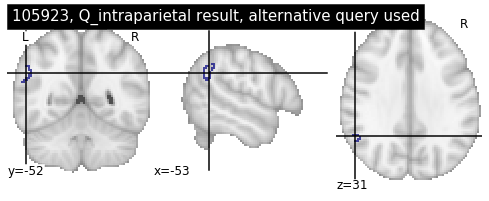

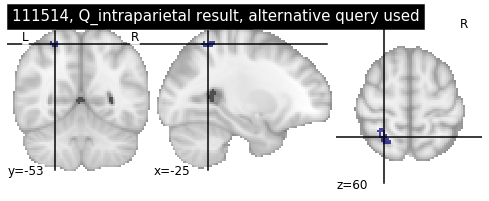

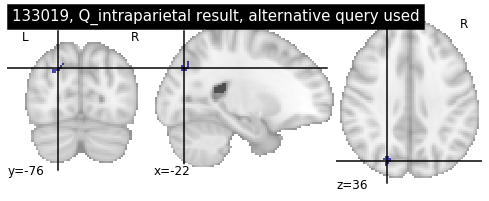

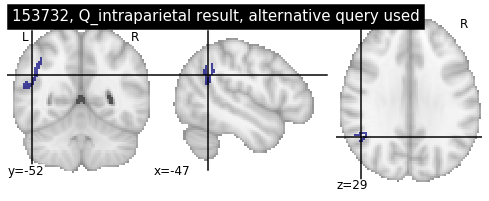

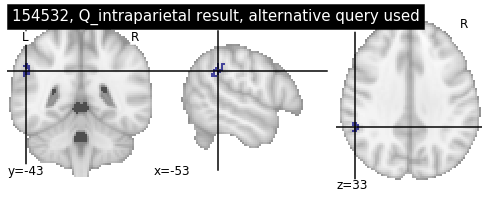

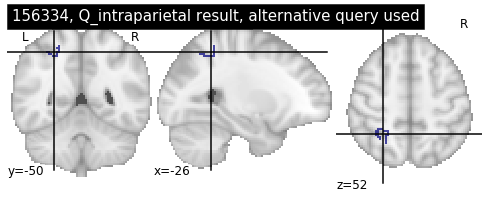

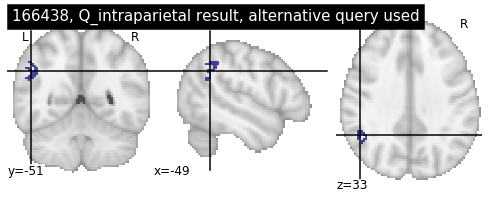

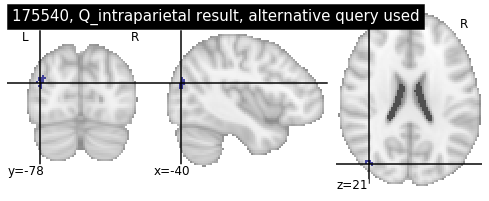

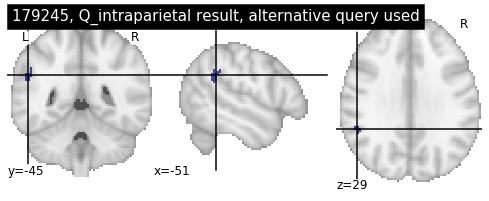

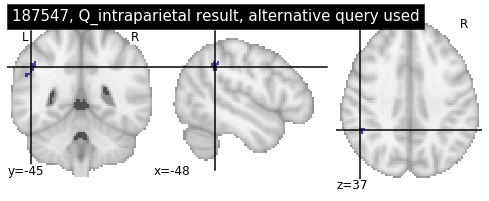

In [18]:
results = [process_subjects(i) for i in subject_ids]

In [21]:
infos=[]
for y in subject_ids:
    i = subject_ids.index(y)
    infos.append(results[i][0][y])
df_infos=pd.DataFrame(data=infos, index=subject_ids)
df_infos.to_pickle('NeuroLang_queries_info_LH')